In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm

In [2]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
import torch.nn.functional as F
from torchvision.transforms import v2
torch.manual_seed(19)

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [3]:
transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPerspective(0.4),
    v2.ToDtype(torch.float32)
])


class NMINSTImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images1 = np.load(img_dir_file + 'train_MNIST_Voxel1_trilinear_x_resolution.npy').astype(np.float32)
        self.labels1 = np.load(img_dir_file + 'train_MNIST_Voxel1_trilinear_y_resolution.npy')
        self.images2 = np.load(img_dir_file + 'train_MNIST_Voxel2_trilinear_x_resolution.npy').astype(np.float32)
        self.labels2 = np.load(img_dir_file + 'train_MNIST_Voxel2_trilinear_y_resolution.npy')
        self.images3 = np.load(img_dir_file + 'train_MNIST_Voxel3_trilinear_x_resolution.npy').astype(np.float32)
        self.labels3 = np.load(img_dir_file + 'train_MNIST_Voxel3_trilinear_y_resolution.npy')

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels1) + len(self.labels2) + len(self.labels3)

    def __getitem__(self, idx):
        if idx//10000 == 0:
            image = self.images1[idx%10000]
            label = self.labels1[idx%10000]
        elif idx//10000 == 1:
            image = self.images2[idx%10000]
            label = self.labels2[idx%10000]
        elif idx//10000 == 2:
            image = self.images3[idx%10000]
            label = self.labels3[idx%10000]

        label_temp = np.zeros((10,))
        label_temp[label] = 1
        if self.stage == 0:
            return self.transform(torch.tensor(image)), torch.tensor(label_temp)
        else:
            return torch.tensor(image), torch.tensor(label_temp)
        
    def set_stage(self, stage):
        self.stage = stage

In [4]:
from torch.utils.data import DataLoader
data = NMINSTImageDataset("Datasety/", transform=transforms)
generator1 = torch.Generator().manual_seed(42)
test_data, training_data = torch.utils.data.random_split(data, [0.3, 0.7], generator=generator1)

del data

In [5]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [6]:
from torch import nn

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU(inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.Hardtanh(min_val=0,max_val=1,inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = self.relu(out)
        else:
            out = self.relu(out)   # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2, in_channels = 5):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 64, kernel_size = 7, stride = 1, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.1)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.relu(x)
        # x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 80, start_factor=1.0, end_factor=0.01, total_iters=70):
        best_accuracy = 0.0
        total_step = len(train_loader)
        train_accuracy_h = []
        test_accuracy_h = []
        train_loss_h = []
        test_loss_h = []
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.0025, momentum = 0.9)  
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)#LinearLR(optimizer,  start_factor=start_factor, end_factor=end_factor, total_iters=total_iters)
        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            running_loss = 0.0
            train_loader.dataset.dataset.set_stage(0)
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.FloatTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                regularization_loss = 0
                for param in self.parameters():
                    regularization_loss += torch.sum(torch.abs(param))
                loss = criterion(outputs, labels) + 0.0001*regularization_loss
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)
                running_loss += loss.item()
                del images, labels, outputs
            train_accuracy_h.append((float(correct))/total)
            train_loss_h.append(running_loss/len(train_loader))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))

            scheduler.step()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                valid_loader.dataset.dataset.set_stage(1)
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.FloatTensor)
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet_MNIST_DVS_ReLU_ReLU1_ReLUmaxpool_EST_FC2__128x128_pretrained_aug_correct_trilinear_mixed_L1_L2.pt")
                test_accuracy_h.append((float(correct))/total)
                test_loss_h.append(val_loss/len(valid_loader))
                print('Accuracy of the network: {} Loss: {}%'.format( 100 * correct / total, val_loss/len(valid_loader)))
        return train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h

In [8]:
# creating the model

model_resnet = ResNet(ResidualBlock, [3, 4, 6, 3], in_channels = 5, num_classes = 10).to("cuda")


In [9]:
model_resnet

ResNet(
  (conv1): Sequential(
    (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (relu): Hardtanh(min_val=0, max_val=1)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchN

In [10]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
print(model)

Using cache found in C:\Users\nikos/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
for param in model_resnet.parameters():
    print(param)

Parameter containing:
tensor([[[[ 5.9876e-02, -3.8350e-02,  4.8545e-02,  ..., -3.6273e-02,
           -4.8656e-02, -1.7670e-02],
          [-6.1756e-02,  4.4762e-02,  5.9028e-02,  ..., -2.6239e-02,
           -6.0549e-02, -5.2502e-02],
          [-1.5317e-03, -5.2905e-02,  1.0469e-02,  ...,  2.9279e-02,
           -8.8815e-03, -2.8577e-02],
          ...,
          [-4.9345e-02, -1.2331e-02,  5.2742e-02,  ...,  5.6190e-02,
            6.1570e-02, -1.6913e-02],
          [-3.5374e-02, -5.4466e-02, -4.0142e-03,  ...,  5.3102e-02,
           -3.9161e-03,  1.8653e-03],
          [-3.6164e-02, -3.8680e-02, -6.3424e-02,  ...,  2.0033e-02,
           -4.2555e-02, -7.6309e-05]],

         [[ 2.6723e-02,  1.3394e-02, -2.3181e-03,  ..., -4.8380e-02,
           -5.8780e-02, -4.4288e-02],
          [-9.1225e-03, -7.4287e-03,  1.2812e-02,  ...,  1.0914e-02,
            5.3184e-02,  1.3259e-02],
          [ 1.3608e-02, -1.8532e-02, -3.2773e-02,  ...,  3.0816e-02,
            2.7003e-02,  1.6127e-02]

### Copy of a weights

In [12]:
size_layer = [3, 4, 6, 3]
layers = [(model_resnet.layer0, model.layer1), (model_resnet.layer1, model.layer2), (model_resnet.layer2, model.layer3), (model_resnet.layer3, model.layer4)]
for n in range(len(layers)):
    for i in range(size_layer[n]):
        layers[n][0][i].conv1[0] = layers[n][1][i].conv1
        layers[n][0][i].conv1[0].stride = 1
        layers[n][0][i].conv2[0] = layers[n][1][i].conv2
        layers[n][0][i].conv2[0].stride = 1
        
        layers[n][0][i].conv1[1] = layers[n][1][i].bn1
        layers[n][0][i].conv2[1] = layers[n][1][i].bn2

model_resnet.layer1[0].downsample[0] = model.layer2[0].downsample[0]
model_resnet.layer1[0].downsample[0].stride = 1
model_resnet.layer1[0].downsample[1] = model.layer2[0].downsample[1]

model_resnet.layer2[0].downsample[0] = model.layer3[0].downsample[0]
model_resnet.layer2[0].downsample[0].stride = 1
model_resnet.layer2[0].downsample[1] = model.layer3[0].downsample[1]

model_resnet.layer3[0].downsample[0] = model.layer4[0].downsample[0]
model_resnet.layer3[0].downsample[0].stride = 1
model_resnet.layer3[0].downsample[1] = model.layer4[0].downsample[1]

model_resnet.to("cuda")

ResNet(
  (conv1): Sequential(
    (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (relu): Hardtanh(min_val=0, max_val=1)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=F

In [13]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[[[ 5.4109e-03, -6.9092e-03,  7.8839e-03,  ...,  4.9072e-02,
            3.0660e-02,  2.5398e-02],
          [ 4.1081e-02,  3.1296e-02,  3.2265e-02,  ...,  3.3145e-02,
            2.9754e-02,  4.1735e-02],
          [ 4.9519e-03, -3.1705e-02, -6.1310e-02,  ..., -9.7493e-02,
           -1.1601e-01, -1.2191e-01],
          ...,
          [-1.2287e-02, -2.4841e-02, -9.3052e-03,  ...,  1.7113e-02,
            2.4631e-03,  1.6726e-02],
          [ 3.9117e-03,  4.4537e-03,  3.6315e-02,  ...,  1.0371e-01,
            7.3973e-02,  5.9085e-02],
          [ 1.6784e-02,  8.8902e-03,  3.1312e-02,  ...,  9.6964e-02,
            8.3749e-02,  9.6970e-02]],

         [[-7.7192e-03, -8.7711e-03,  1.4143e-02,  ...,  3.3901e-02,
            2.5483e-02,  2.4275e-02],
          [ 5.3961e-02,  4.4677e-02,  3.4326e-02,  ...,  1.3392e-02,
            1.9135e-02,  3.7995e-02],
          [ 1.0251e-03, -5.4513e-02, -1.0225e-01,  ..., -1.9231e-01,
           -1.9994e-01, -1.8192e-01]

In [14]:
for param in model_resnet.parameters():
    print(param)

Parameter containing:
tensor([[[[ 5.9876e-02, -3.8350e-02,  4.8545e-02,  ..., -3.6273e-02,
           -4.8656e-02, -1.7670e-02],
          [-6.1756e-02,  4.4762e-02,  5.9028e-02,  ..., -2.6239e-02,
           -6.0549e-02, -5.2502e-02],
          [-1.5317e-03, -5.2905e-02,  1.0469e-02,  ...,  2.9279e-02,
           -8.8815e-03, -2.8577e-02],
          ...,
          [-4.9345e-02, -1.2331e-02,  5.2742e-02,  ...,  5.6190e-02,
            6.1570e-02, -1.6913e-02],
          [-3.5374e-02, -5.4466e-02, -4.0142e-03,  ...,  5.3102e-02,
           -3.9161e-03,  1.8653e-03],
          [-3.6164e-02, -3.8680e-02, -6.3424e-02,  ...,  2.0033e-02,
           -4.2555e-02, -7.6309e-05]],

         [[ 2.6723e-02,  1.3394e-02, -2.3181e-03,  ..., -4.8380e-02,
           -5.8780e-02, -4.4288e-02],
          [-9.1225e-03, -7.4287e-03,  1.2812e-02,  ...,  1.0914e-02,
            5.3184e-02,  1.3259e-02],
          [ 1.3608e-02, -1.8532e-02, -3.2773e-02,  ...,  3.0816e-02,
            2.7003e-02,  1.6127e-02]

In [15]:
train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h = model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=120,save_best=True, save_thr=90) #, learning_rate=5e-4

100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [1/120], Step [657/657], Loss: 13.4875, Accuracy: 0.1983
Accuracy of the network: 27.366666666666667 Loss: 1.749937577873257%


100%|██████████| 657/657 [02:29<00:00,  4.38it/s]


Epoch [2/120], Step [657/657], Loss: 4.6434, Accuracy: 0.4026
Accuracy of the network: 49.25555555555555 Loss: 1.3042145024800131%


100%|██████████| 657/657 [02:29<00:00,  4.39it/s]


Epoch [3/120], Step [657/657], Loss: 4.1296, Accuracy: 0.5959
Accuracy of the network: 66.4888888888889 Loss: 0.890149602547605%


100%|██████████| 657/657 [02:24<00:00,  4.55it/s]


Epoch [4/120], Step [657/657], Loss: 3.7727, Accuracy: 0.6722
Accuracy of the network: 75.47777777777777 Loss: 0.6909688516711512%


100%|██████████| 657/657 [02:26<00:00,  4.50it/s]


Epoch [5/120], Step [657/657], Loss: 3.5888, Accuracy: 0.7035
Accuracy of the network: 73.75555555555556 Loss: 0.708320566948424%


100%|██████████| 657/657 [02:24<00:00,  4.55it/s]


Epoch [6/120], Step [657/657], Loss: 3.4198, Accuracy: 0.7208
Accuracy of the network: 75.11111111111111 Loss: 0.710882879106711%


100%|██████████| 657/657 [02:19<00:00,  4.70it/s]


Epoch [7/120], Step [657/657], Loss: 3.2778, Accuracy: 0.7381
Accuracy of the network: 78.7 Loss: 0.6179064344218437%


100%|██████████| 657/657 [02:23<00:00,  4.58it/s]


Epoch [8/120], Step [657/657], Loss: 3.1878, Accuracy: 0.7486
Accuracy of the network: 78.08888888888889 Loss: 0.6500454628509833%


100%|██████████| 657/657 [02:22<00:00,  4.62it/s]


Epoch [9/120], Step [657/657], Loss: 3.0109, Accuracy: 0.7606
Accuracy of the network: 75.84444444444445 Loss: 0.6642255734467337%


100%|██████████| 657/657 [02:27<00:00,  4.46it/s]


Epoch [10/120], Step [657/657], Loss: 2.8752, Accuracy: 0.7691
Accuracy of the network: 82.06666666666666 Loss: 0.5292122467084134%


100%|██████████| 657/657 [02:21<00:00,  4.64it/s]


Epoch [11/120], Step [657/657], Loss: 2.7017, Accuracy: 0.7839
Accuracy of the network: 80.57777777777778 Loss: 0.5856053404351498%


100%|██████████| 657/657 [02:27<00:00,  4.44it/s]


Epoch [12/120], Step [657/657], Loss: 2.6254, Accuracy: 0.7857
Accuracy of the network: 78.82222222222222 Loss: 0.5772001660356285%


100%|██████████| 657/657 [02:26<00:00,  4.48it/s]


Epoch [13/120], Step [657/657], Loss: 2.4785, Accuracy: 0.7973
Accuracy of the network: 85.93333333333334 Loss: 0.40997773393037473%


100%|██████████| 657/657 [02:27<00:00,  4.45it/s]


Epoch [14/120], Step [657/657], Loss: 2.3510, Accuracy: 0.8050
Accuracy of the network: 82.71111111111111 Loss: 0.5060517662171776%


100%|██████████| 657/657 [02:27<00:00,  4.45it/s]


Epoch [15/120], Step [657/657], Loss: 2.2368, Accuracy: 0.8149
Accuracy of the network: 84.86666666666666 Loss: 0.44328397871754693%


100%|██████████| 657/657 [02:25<00:00,  4.51it/s]


Epoch [16/120], Step [657/657], Loss: 2.1402, Accuracy: 0.8188
Accuracy of the network: 84.53333333333333 Loss: 0.4657343897096654%


100%|██████████| 657/657 [02:23<00:00,  4.57it/s]


Epoch [17/120], Step [657/657], Loss: 2.0383, Accuracy: 0.8285
Accuracy of the network: 86.1 Loss: 0.40981247387033826%


100%|██████████| 657/657 [02:24<00:00,  4.56it/s]


Epoch [18/120], Step [657/657], Loss: 1.9457, Accuracy: 0.8270
Accuracy of the network: 87.38888888888889 Loss: 0.40492912963138405%


100%|██████████| 657/657 [02:28<00:00,  4.42it/s]


Epoch [19/120], Step [657/657], Loss: 1.8907, Accuracy: 0.8339
Accuracy of the network: 86.11111111111111 Loss: 0.4060638021968358%


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [20/120], Step [657/657], Loss: 1.7768, Accuracy: 0.8420
Accuracy of the network: 85.84444444444445 Loss: 0.4116107519214035%


100%|██████████| 657/657 [02:25<00:00,  4.51it/s]


Epoch [21/120], Step [657/657], Loss: 1.6772, Accuracy: 0.8463
Accuracy of the network: 88.41111111111111 Loss: 0.3543154293446676%


100%|██████████| 657/657 [02:25<00:00,  4.50it/s]


Epoch [22/120], Step [657/657], Loss: 1.5987, Accuracy: 0.8544
Accuracy of the network: 86.8 Loss: 0.3845618106160604%


100%|██████████| 657/657 [02:24<00:00,  4.56it/s]


Epoch [23/120], Step [657/657], Loss: 1.5308, Accuracy: 0.8597
Accuracy of the network: 89.71111111111111 Loss: 0.31229015764720897%


100%|██████████| 657/657 [02:27<00:00,  4.46it/s]


Epoch [24/120], Step [657/657], Loss: 1.4490, Accuracy: 0.8631
Accuracy of the network: 87.54444444444445 Loss: 0.37280834867810525%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [25/120], Step [657/657], Loss: 1.3718, Accuracy: 0.8669
Accuracy of the network: 89.5 Loss: 0.3198949798466043%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [26/120], Step [657/657], Loss: 1.3209, Accuracy: 0.8704
Accuracy of the network: 89.12222222222222 Loss: 0.33708364963003085%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [27/120], Step [657/657], Loss: 1.2649, Accuracy: 0.8722
Accuracy of the network: 89.27777777777777 Loss: 0.3343012941908752%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [28/120], Step [657/657], Loss: 1.1796, Accuracy: 0.8816
Accuracy of the network: 89.17777777777778 Loss: 0.3235683334423295%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [29/120], Step [657/657], Loss: 1.1695, Accuracy: 0.8796
Accuracy of the network: 89.75555555555556 Loss: 0.3082278205993328%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [30/120], Step [657/657], Loss: 1.0866, Accuracy: 0.8893
Accuracy of the network: 90.95555555555555 Loss: 0.27888868930122107%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [31/120], Step [657/657], Loss: 1.0474, Accuracy: 0.8881
Accuracy of the network: 91.13333333333334 Loss: 0.2779859836536942%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [32/120], Step [657/657], Loss: 1.0093, Accuracy: 0.8913
Accuracy of the network: 91.46666666666667 Loss: 0.2666115753141278%


100%|██████████| 657/657 [02:27<00:00,  4.46it/s]


Epoch [33/120], Step [657/657], Loss: 0.9752, Accuracy: 0.8923
Accuracy of the network: 92.11111111111111 Loss: 0.2563990461012573%


100%|██████████| 657/657 [02:27<00:00,  4.46it/s]


Epoch [34/120], Step [657/657], Loss: 0.9224, Accuracy: 0.8972
Accuracy of the network: 91.97777777777777 Loss: 0.2577748879103373%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [35/120], Step [657/657], Loss: 0.9078, Accuracy: 0.8970
Accuracy of the network: 92.17777777777778 Loss: 0.2410927314892517%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [36/120], Step [657/657], Loss: 0.8514, Accuracy: 0.9054
Accuracy of the network: 91.45555555555555 Loss: 0.25756253996956435%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [37/120], Step [657/657], Loss: 0.8349, Accuracy: 0.9051
Accuracy of the network: 91.58888888888889 Loss: 0.2488401379991085%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [38/120], Step [657/657], Loss: 0.7996, Accuracy: 0.9049
Accuracy of the network: 91.93333333333334 Loss: 0.26654599540939566%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [39/120], Step [657/657], Loss: 0.7628, Accuracy: 0.9076
Accuracy of the network: 92.66666666666667 Loss: 0.22621974444135706%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [40/120], Step [657/657], Loss: 0.7206, Accuracy: 0.9129
Accuracy of the network: 93.13333333333334 Loss: 0.22395346112919193%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [41/120], Step [657/657], Loss: 0.7011, Accuracy: 0.9121
Accuracy of the network: 92.33333333333333 Loss: 0.24707410341881691%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [42/120], Step [657/657], Loss: 0.6742, Accuracy: 0.9155
Accuracy of the network: 93.74444444444444 Loss: 0.21088912874354537%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [43/120], Step [657/657], Loss: 0.6436, Accuracy: 0.9177
Accuracy of the network: 93.26666666666667 Loss: 0.213960593169991%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [44/120], Step [657/657], Loss: 0.6270, Accuracy: 0.9176
Accuracy of the network: 91.54444444444445 Loss: 0.2620153496609935%


100%|██████████| 657/657 [02:27<00:00,  4.46it/s]


Epoch [45/120], Step [657/657], Loss: 0.5921, Accuracy: 0.9240
Accuracy of the network: 93.45555555555555 Loss: 0.20864468170924388%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [46/120], Step [657/657], Loss: 0.5809, Accuracy: 0.9207
Accuracy of the network: 94.03333333333333 Loss: 0.1979023848812208%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [47/120], Step [657/657], Loss: 0.5527, Accuracy: 0.9249
Accuracy of the network: 93.72222222222223 Loss: 0.20531937598865083%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [48/120], Step [657/657], Loss: 0.5284, Accuracy: 0.9252
Accuracy of the network: 94.0 Loss: 0.1892788182243916%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [49/120], Step [657/657], Loss: 0.5183, Accuracy: 0.9266
Accuracy of the network: 94.04444444444445 Loss: 0.191158306263123%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [50/120], Step [657/657], Loss: 0.5003, Accuracy: 0.9266
Accuracy of the network: 94.6 Loss: 0.17576991162322303%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [51/120], Step [657/657], Loss: 0.4835, Accuracy: 0.9302
Accuracy of the network: 93.74444444444444 Loss: 0.19952923433313555%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [52/120], Step [657/657], Loss: 0.4677, Accuracy: 0.9303
Accuracy of the network: 94.81111111111112 Loss: 0.16654320542059892%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [53/120], Step [657/657], Loss: 0.4541, Accuracy: 0.9315
Accuracy of the network: 94.8 Loss: 0.17668988763070698%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [54/120], Step [657/657], Loss: 0.4291, Accuracy: 0.9358
Accuracy of the network: 94.94444444444444 Loss: 0.16733282189552032%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [55/120], Step [657/657], Loss: 0.4243, Accuracy: 0.9354
Accuracy of the network: 94.65555555555555 Loss: 0.18074564467983464%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [56/120], Step [657/657], Loss: 0.4104, Accuracy: 0.9379
Accuracy of the network: 94.72222222222223 Loss: 0.16949921680601143%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [57/120], Step [657/657], Loss: 0.3976, Accuracy: 0.9398
Accuracy of the network: 94.73333333333333 Loss: 0.17452403288070403%


100%|██████████| 657/657 [02:26<00:00,  4.48it/s]


Epoch [58/120], Step [657/657], Loss: 0.3885, Accuracy: 0.9396
Accuracy of the network: 94.46666666666667 Loss: 0.17955549954971733%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [59/120], Step [657/657], Loss: 0.3746, Accuracy: 0.9440
Accuracy of the network: 95.12222222222222 Loss: 0.1594392564742172%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [60/120], Step [657/657], Loss: 0.3708, Accuracy: 0.9414
Accuracy of the network: 95.07777777777778 Loss: 0.16515180801457546%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [61/120], Step [657/657], Loss: 0.3559, Accuracy: 0.9420
Accuracy of the network: 94.32222222222222 Loss: 0.18845951779091613%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [62/120], Step [657/657], Loss: 0.3518, Accuracy: 0.9445
Accuracy of the network: 95.03333333333333 Loss: 0.162283016434798%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [63/120], Step [657/657], Loss: 0.3418, Accuracy: 0.9447
Accuracy of the network: 95.62222222222222 Loss: 0.1503973389572814%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [64/120], Step [657/657], Loss: 0.3301, Accuracy: 0.9457
Accuracy of the network: 95.53333333333333 Loss: 0.15253502404621094%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [65/120], Step [657/657], Loss: 0.3326, Accuracy: 0.9437
Accuracy of the network: 95.37777777777778 Loss: 0.15331155083518713%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [66/120], Step [657/657], Loss: 0.3198, Accuracy: 0.9458
Accuracy of the network: 95.44444444444444 Loss: 0.15231276007620156%


100%|██████████| 657/657 [02:27<00:00,  4.46it/s]


Epoch [67/120], Step [657/657], Loss: 0.3075, Accuracy: 0.9480
Accuracy of the network: 95.41111111111111 Loss: 0.1529032351409501%


100%|██████████| 657/657 [02:27<00:00,  4.46it/s]


Epoch [68/120], Step [657/657], Loss: 0.3057, Accuracy: 0.9481
Accuracy of the network: 95.42222222222222 Loss: 0.1523602593901521%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [69/120], Step [657/657], Loss: 0.3039, Accuracy: 0.9459
Accuracy of the network: 95.54444444444445 Loss: 0.14810131420876751%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [70/120], Step [657/657], Loss: 0.2923, Accuracy: 0.9495
Accuracy of the network: 95.85555555555555 Loss: 0.1439079631463433%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [71/120], Step [657/657], Loss: 0.2959, Accuracy: 0.9471
Accuracy of the network: 95.97777777777777 Loss: 0.1380529102558891%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [72/120], Step [657/657], Loss: 0.2803, Accuracy: 0.9503
Accuracy of the network: 95.96666666666667 Loss: 0.14071352484616192%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [73/120], Step [657/657], Loss: 0.2760, Accuracy: 0.9530
Accuracy of the network: 95.73333333333333 Loss: 0.1429453894548805%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [74/120], Step [657/657], Loss: 0.2718, Accuracy: 0.9526
Accuracy of the network: 95.73333333333333 Loss: 0.146496831201651%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [75/120], Step [657/657], Loss: 0.2654, Accuracy: 0.9528
Accuracy of the network: 95.88888888888889 Loss: 0.1401022438567581%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [76/120], Step [657/657], Loss: 0.2624, Accuracy: 0.9517
Accuracy of the network: 95.83333333333333 Loss: 0.1414353114466929%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [77/120], Step [657/657], Loss: 0.2583, Accuracy: 0.9529
Accuracy of the network: 95.73333333333333 Loss: 0.14248207589307577%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [78/120], Step [657/657], Loss: 0.2523, Accuracy: 0.9537
Accuracy of the network: 96.0 Loss: 0.13448979913633555%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [79/120], Step [657/657], Loss: 0.2488, Accuracy: 0.9543
Accuracy of the network: 95.66666666666667 Loss: 0.1396509835707909%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [80/120], Step [657/657], Loss: 0.2491, Accuracy: 0.9528
Accuracy of the network: 95.88888888888889 Loss: 0.13649733140007825%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [81/120], Step [657/657], Loss: 0.2412, Accuracy: 0.9547
Accuracy of the network: 96.14444444444445 Loss: 0.1305723500087963%


100%|██████████| 657/657 [02:26<00:00,  4.48it/s]


Epoch [82/120], Step [657/657], Loss: 0.2397, Accuracy: 0.9558
Accuracy of the network: 96.03333333333333 Loss: 0.13064792134686776%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [83/120], Step [657/657], Loss: 0.2336, Accuracy: 0.9567
Accuracy of the network: 95.66666666666667 Loss: 0.1446727505217947%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [84/120], Step [657/657], Loss: 0.2313, Accuracy: 0.9570
Accuracy of the network: 96.2 Loss: 0.13310750534903285%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [85/120], Step [657/657], Loss: 0.2313, Accuracy: 0.9546
Accuracy of the network: 95.92222222222222 Loss: 0.13329332423601167%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [86/120], Step [657/657], Loss: 0.2263, Accuracy: 0.9574
Accuracy of the network: 95.91111111111111 Loss: 0.1400065678733249%


100%|██████████| 657/657 [02:26<00:00,  4.48it/s]


Epoch [87/120], Step [657/657], Loss: 0.2215, Accuracy: 0.9575
Accuracy of the network: 95.97777777777777 Loss: 0.13335300121350702%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [88/120], Step [657/657], Loss: 0.2166, Accuracy: 0.9587
Accuracy of the network: 96.15555555555555 Loss: 0.13230228093816032%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [89/120], Step [657/657], Loss: 0.2221, Accuracy: 0.9577
Accuracy of the network: 96.26666666666667 Loss: 0.12501997144972074%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [90/120], Step [657/657], Loss: 0.2139, Accuracy: 0.9584
Accuracy of the network: 96.11111111111111 Loss: 0.12825481155689092%


100%|██████████| 657/657 [02:26<00:00,  4.48it/s]


Epoch [91/120], Step [657/657], Loss: 0.2187, Accuracy: 0.9555
Accuracy of the network: 96.14444444444445 Loss: 0.13009467129166244%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [92/120], Step [657/657], Loss: 0.2139, Accuracy: 0.9590
Accuracy of the network: 96.23333333333333 Loss: 0.12827065761419051%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [93/120], Step [657/657], Loss: 0.2089, Accuracy: 0.9574
Accuracy of the network: 96.14444444444445 Loss: 0.12712524257970195%


100%|██████████| 657/657 [02:27<00:00,  4.46it/s]


Epoch [94/120], Step [657/657], Loss: 0.2086, Accuracy: 0.9574
Accuracy of the network: 96.21111111111111 Loss: 0.12601105547807318%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [95/120], Step [657/657], Loss: 0.2067, Accuracy: 0.9593
Accuracy of the network: 96.35555555555555 Loss: 0.12384967050178254%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [96/120], Step [657/657], Loss: 0.2006, Accuracy: 0.9618
Accuracy of the network: 96.47777777777777 Loss: 0.12330182404950896%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [97/120], Step [657/657], Loss: 0.2011, Accuracy: 0.9603
Accuracy of the network: 96.07777777777778 Loss: 0.1249670786882176%


100%|██████████| 657/657 [02:26<00:00,  4.48it/s]


Epoch [98/120], Step [657/657], Loss: 0.2009, Accuracy: 0.9610
Accuracy of the network: 96.36666666666666 Loss: 0.12583418504883212%


100%|██████████| 657/657 [02:26<00:00,  4.48it/s]


Epoch [99/120], Step [657/657], Loss: 0.1973, Accuracy: 0.9616
Accuracy of the network: 96.25555555555556 Loss: 0.12289133006772886%


100%|██████████| 657/657 [02:27<00:00,  4.46it/s]


Epoch [100/120], Step [657/657], Loss: 0.1998, Accuracy: 0.9604
Accuracy of the network: 96.46666666666667 Loss: 0.1266056452844794%


100%|██████████| 657/657 [02:27<00:00,  4.46it/s]


Epoch [101/120], Step [657/657], Loss: 0.1974, Accuracy: 0.9610
Accuracy of the network: 96.53333333333333 Loss: 0.12430420163226255%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [102/120], Step [657/657], Loss: 0.1979, Accuracy: 0.9608
Accuracy of the network: 96.21111111111111 Loss: 0.12490281498997557%


100%|██████████| 657/657 [02:33<00:00,  4.27it/s]


Epoch [103/120], Step [657/657], Loss: 0.1933, Accuracy: 0.9617
Accuracy of the network: 96.33333333333333 Loss: 0.12281230726801123%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [104/120], Step [657/657], Loss: 0.1934, Accuracy: 0.9614
Accuracy of the network: 96.5 Loss: 0.12072892281959982%


100%|██████████| 657/657 [02:27<00:00,  4.46it/s]


Epoch [105/120], Step [657/657], Loss: 0.1944, Accuracy: 0.9601
Accuracy of the network: 96.63333333333334 Loss: 0.11948036676906842%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [106/120], Step [657/657], Loss: 0.1878, Accuracy: 0.9625
Accuracy of the network: 96.33333333333333 Loss: 0.12317813475490778%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [107/120], Step [657/657], Loss: 0.1891, Accuracy: 0.9621
Accuracy of the network: 96.61111111111111 Loss: 0.11953424007123244%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [108/120], Step [657/657], Loss: 0.1874, Accuracy: 0.9622
Accuracy of the network: 96.41111111111111 Loss: 0.1229748514328971%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [109/120], Step [657/657], Loss: 0.1870, Accuracy: 0.9621
Accuracy of the network: 96.62222222222222 Loss: 0.12099328063798288%


100%|██████████| 657/657 [02:27<00:00,  4.46it/s]


Epoch [110/120], Step [657/657], Loss: 0.1850, Accuracy: 0.9633
Accuracy of the network: 96.61111111111111 Loss: 0.1198847454061058%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [111/120], Step [657/657], Loss: 0.1866, Accuracy: 0.9615
Accuracy of the network: 96.57777777777778 Loss: 0.12101245161595074%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [112/120], Step [657/657], Loss: 0.1851, Accuracy: 0.9620
Accuracy of the network: 96.44444444444444 Loss: 0.11995542957612597%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [113/120], Step [657/657], Loss: 0.1853, Accuracy: 0.9624
Accuracy of the network: 96.5111111111111 Loss: 0.12086325332337448%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [114/120], Step [657/657], Loss: 0.1817, Accuracy: 0.9636
Accuracy of the network: 96.52222222222223 Loss: 0.11917939506378686%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [115/120], Step [657/657], Loss: 0.1831, Accuracy: 0.9634
Accuracy of the network: 96.53333333333333 Loss: 0.12116112896234643%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [116/120], Step [657/657], Loss: 0.1811, Accuracy: 0.9638
Accuracy of the network: 96.75555555555556 Loss: 0.11910023515819447%


100%|██████████| 657/657 [02:27<00:00,  4.46it/s]


Epoch [117/120], Step [657/657], Loss: 0.1805, Accuracy: 0.9636
Accuracy of the network: 96.6 Loss: 0.11699617566237001%


100%|██████████| 657/657 [02:26<00:00,  4.47it/s]


Epoch [118/120], Step [657/657], Loss: 0.1838, Accuracy: 0.9604
Accuracy of the network: 96.4 Loss: 0.11948161000214147%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [119/120], Step [657/657], Loss: 0.1789, Accuracy: 0.9631
Accuracy of the network: 96.4888888888889 Loss: 0.12253512377381748%


100%|██████████| 657/657 [02:27<00:00,  4.47it/s]


Epoch [120/120], Step [657/657], Loss: 0.1771, Accuracy: 0.9636
Accuracy of the network: 96.55555555555556 Loss: 0.12235907445404123%


In [16]:
torch.save(model_resnet, "best_resnet_MNIST_DVS_ReLU_ReLU1_ReLUmaxpool_EST_FC2_128x128_pretrained_aug_correct_trilinear_mixed_L1_L2.pt")

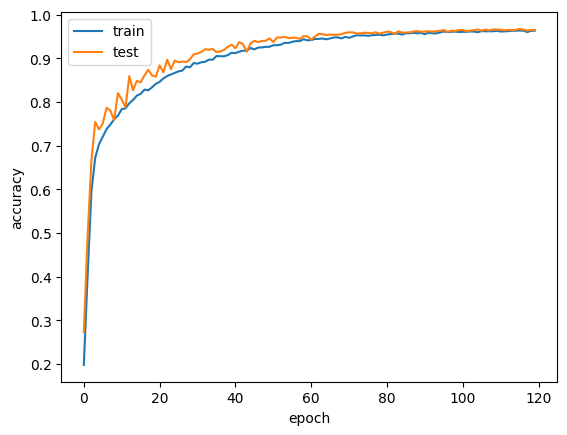

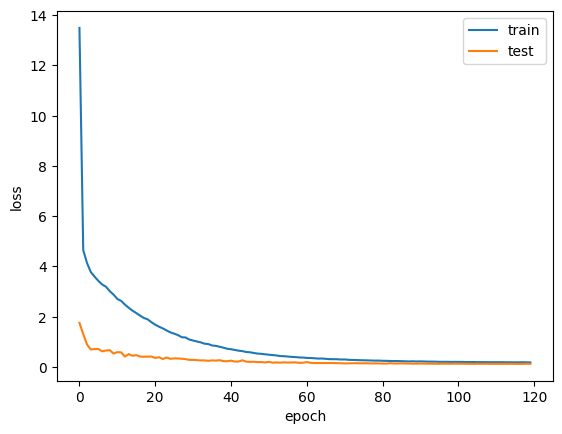

In [17]:
plt.plot(train_accuracy_h, label='train')
plt.plot(test_accuracy_h, label='test')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(train_loss_h, label='train')
plt.plot(test_loss_h, label='test')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [18]:
import pandas as pd
dict = {'train_acc': train_accuracy_h, 'test_acc': test_accuracy_h, 'train_loss': train_loss_h, 'test_loss' : test_loss_h}
df = pd.DataFrame(dict)
df.to_csv('logs/best_resnet_MNIST_DVS_ReLU_ReLU1_ReLUmaxpool_EST_FC2_128x128_pretrained_aug_correct_trilinear_mixed_L1_L2.csv')

In [19]:
df.head()

,train_acc,test_acc,train_loss,test_loss
0,0.198286,0.273667,13.487471,1.749938
1,0.402571,0.492556,4.643369,1.304215
2,0.595857,0.664889,4.129648,0.890150
3,0.672190,0.754778,3.772721,0.690969
4,0.703476,0.737556,3.588808,0.708321


In [20]:
print(df["test_acc"].max())

0.9675555555555555
